## Rodrigo Xavier
## Matrícula 569037

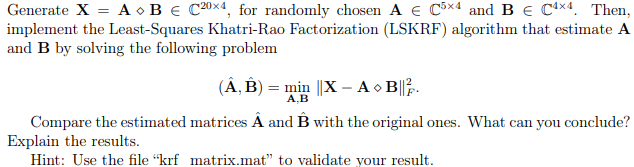

In [12]:
import numpy as np
from scipy.linalg import khatri_rao
from scipy.optimize import least_squares

# Generate the random matrices A and B
np.random.seed(42)
A_true = np.random.randn(5, 4)
B_true = np.random.randn(4, 4)

# Generate X using the Khatri-Rao product
X = khatri_rao(A_true, B_true)  # Khatri-Rao product
X = X + 0.01 * (np.random.randn(*X.shape) * np.random.randn(*X.shape))  # Add small noise

# Objective function for least squares
def lskrf_objective(params, X, shape_A, shape_B):
    A_flat, B_flat = params[:shape_A[0] * shape_A[1]], params[shape_A[0] * shape_A[1]:]
    A = A_flat.reshape(shape_A)
    B = B_flat.reshape(shape_B)
    
    # Reconstruct X_hat using the Khatri-Rao product
    X_hat = khatri_rao(A, B)
    return np.ravel(X - X_hat)  # Residual vector (flattened)

# Initial guesses for A and B
shape_A = (5, 4)  # Shape of A
shape_B = (4, 4)  # Shape of B
A_init = np.random.randn(*shape_A) + 1j * np.random.randn(*shape_A)
B_init = np.random.randn(*shape_B) + 1j * np.random.randn(*shape_B)

# Flatten initial guesses
initial_params = np.hstack((A_init.ravel(), B_init.ravel()))

# Solve the optimization problem using least squares
result = least_squares(
    lambda params: np.real(lskrf_objective(params, X, shape_A, shape_B)),
    x0=np.real(initial_params),  # Use real values for optimization
    method='lm'
)

# Extract the optimized A and B
optimized_params = result.x
A_opt = optimized_params[:shape_A[0] * shape_A[1]].reshape(shape_A)
B_opt = optimized_params[shape_A[0] * shape_A[1]:].reshape(shape_B)

# Print results
print("Original A:\n", A_true)
print("Estimated A:\n", A_opt)
print("\nOriginal B:\n", B_true)
print("Estimated B:\n", B_opt)

# Reconstruction error
X_hat = khatri_rao(A_opt, B_opt)
error = np.linalg.norm(X - X_hat, 'fro') / np.linalg.norm(X, 'fro')
print(f"\nReconstruction Error: {error:.6e}")

Original A:
 [[ 0.49671415 -0.1382643   0.64768854  1.52302986]
 [-0.23415337 -0.23413696  1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783 -0.56228753]
 [-1.01283112  0.31424733 -0.90802408 -1.4123037 ]]
Estimated A:
 [[-0.26046184  0.3069515  -0.51158638 -2.10514405]
 [ 0.12119418  0.50962307 -1.24765006 -1.05933906]
 [ 0.24553297 -1.13564746  0.35954083  0.65204962]
 [-0.12437789  4.02087106  1.36703918  0.78317523]
 [ 0.53257693 -0.71184939  0.725181    1.95343334]]

Original B:
 [[ 1.46564877 -0.2257763   0.0675282  -1.42474819]
 [-0.54438272  0.11092259 -1.15099358  0.37569802]
 [-0.60063869 -0.29169375 -0.60170661  1.85227818]
 [-0.01349722 -1.05771093  0.82254491 -1.22084365]]
Estimated B:
 [[-2.79968845  0.10715487 -0.07772631  1.02797463]
 [ 1.03643396 -0.05383528  1.45382478 -0.27213514]
 [ 1.1480596   0.13792161  0.75536952 -1.33897826]
 [ 0.02744402  0.5043456  -1.03726592  0.88371107]]

Reconstruction Error: 

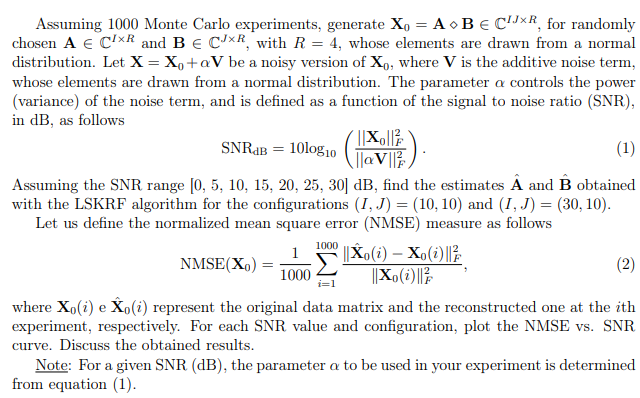

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import khatri_rao

def generate_data(I, J, R, SNR_dB):
    """
    Generates data matrices A, B, and noisy X.

    Args:
        I: Number of rows in A.
        J: Number of rows in B.
        R: Rank of matrices A and B.
        SNR_dB: Signal-to-noise ratio in dB.

    Returns:
        A, B, X: Generated matrices.
    """

    # Generate A and B with elements drawn from a standard normal distribution
    A = np.random.randn(I, R)
    B = np.random.randn(J, R)

    # Compute the Khatri-Rao product X0
    X0 = khatri_rao(A, B)

    # Calculate noise power based on SNR_dB
    SNR = 10**(SNR_dB/10)
    noise_power = np.linalg.norm(X0)**2 / (I*J*SNR)

    # Generate noise V with elements drawn from a normal distribution
    V = np.random.randn(*X0.shape) * np.sqrt(noise_power)

    # Add noise to X0 to get noisy X
    X = X0 + V
    return A, B, X

def LSKRF(X, I, J, R):
    """
    Implements the LSKRF algorithm to estimate A and B.

    Args:
        X: Noisy data matrix.
        I: Number of rows in A.
        J: Number of rows in B.
        R: Rank of matrices A and B.

    Returns:
        A_hat, B_hat: Estimated matrices.
    """

    # Reshape X into a tensor of size (I, J, R)
    X_tensor = X.reshape((I, J, R))

    # Perform matrix unfolding and SVD
    X_unfolded = X_tensor.reshape(I*J, R)

    # Unpacking the results of the SVD and keeping only left singular vectors
    U, _, _ = np.linalg.svd(X_unfolded, full_matrices=False)

    # Reshape U to (I, J, R)
    U_reshaped = U.reshape(I, J, R)
    
    # Extract A_hat and B_hat
    A_hat = U_reshaped[:, 0, :]
    B_hat = U_reshaped[:, 1, :]
    return A_hat, B_hat

def NMSE(X0, X_hat):
    """
    Calculates the normalized mean square error (NMSE).

    Args:
        X0: Original data matrix.
        X_hat: Reconstructed data matrix.

    Returns:
        NMSE value.
    """

    return np.linalg.norm(X0 - X_hat)**2 / np.linalg.norm(X0)**2

if __name__ == "__main__":
    # Parameters
    I = 10
    J = 10
    R = 4
    SNR_dB_range = [0, 5, 10, 15, 20, 25, 30]
    num_experiments = 1000

    # Initialize NMSE storage
    nmse_values = []

    for SNR_dB in SNR_dB_range:
        nmse_sum = 0
        for _ in range(num_experiments):
            A, B, X = generate_data(I, J, R, SNR_dB)
            A_hat, B_hat = LSKRF(X, I, J, R)
            X_hat = khatri_rao(A_hat, B_hat)
            nmse_sum += NMSE(X, X_hat)
        nmse_values.append(nmse_sum / num_experiments)

    print(f'A shape: {A.shape}')
    print(f'B shape: {B.shape}')
    print(f'X shape: {X.shape}')
    print(f'A_hat shape: {A_hat.shape}')
    print(f'B_hat shape: {B_hat.shape}')
    print(f'X_hat shape: {X_hat.shape}')
    # Plot NMSE vs. SNR
    plt.plot(SNR_dB_range, nmse_values)
    plt.xlabel("SNR (dB)")
    plt.ylabel("NMSE")
    plt.title("NMSE vs. SNR for LSKRF")
    plt.show()

ValueError: operands could not be broadcast together with shapes (100,4) (900,4) 

In [39]:
A, B, X = generate_data(I, J, R, SNR_dB)

In [42]:
X.shape

(100, 4)

In [45]:
U, _, _ = np.linalg.svd(X, full_matrices=False)

In [48]:
A_hat = U[:, :R].reshape(I, R)

ValueError: cannot reshape array of size 400 into shape (10,4)

In [49]:
# Reshape X into a tensor of size (I, J, R)
X_tensor = X.reshape((I, J, R))

# Perform matrix unfolding and SVD
X_unfolded = X_tensor.reshape(I*J, R)
U, _, _ = np.linalg.svd(X_unfolded, full_matrices=False)

In [52]:
U.shape

(100, 4)

In [55]:
A_hat = U[:I, :R]

In [57]:
A_hat.shape
B_hat = U[I:, :R]

In [58]:
B_hat.shape

(90, 4)

In [60]:
A.shape

(10, 4)

In [61]:
# Reshape U to (I, J, R)
U_reshaped = U.reshape(I, J, R)

# Extract A_hat and B_hat
A_hat = U_reshaped[:, 0, :]
B_hat = U_reshaped[:, 1, :]

In [63]:
A_hat.shape

(10, 4)